# Прогнозирование температуры звезды (python 3.12.3)

# Цель проекта
Создать нейронную сеть для предсказания абсолютной температуры поверхности звезды, обеспечивая более точный и удобный метод, чем традиционные подходы (закон смещения Вина, закон Стефана-Больцмана, спектральный анализ).

# Описание задачи
- Использовать данные по 240 звездам, включающие:
  - Относительную светимость (L/Lo)
  - Относительный радиус (R/Ro)
  - Абсолютную звёздную величину (Mv)
  - Звёздный цвет (на основе спектрального анализа)
  - Тип звезды (с кодированием: 0 — коричневый карлик, 1 — красный карлик, 2 — белый карлик, 3 — звёзды главной последовательности, 4 — сверхгигант, 5 — гипергигант)
- Провести предобработку и анализ данных для выявления ключевых признаков.
- Разработать, обучить и протестировать нейронную сеть для предсказания абсолютной температуры звезды.
- Сравнить точность модели с традиционными методами расчёта температуры.


# Обзор данных

## Библиотеки

### Обновление

In [1]:
#!conda install -q phik
#!conda install plotly --upgrade -q
#!conda install --upgrade scikit-learn -q
#!conda install -q mlxtend
#!conda install -q shap
#!conda install matplotlib -q
#!conda install --upgrade imbalanced-learn
#!conda install --upgrade matplotlib
#!conda install --upgrade pandas numpy
#!conda install numpy -q
#!pip uninstall xgboost -y
#!pip install torch
#!pip install tensorflow

### Импорт

In [2]:
# ------------------------------
# Стандартная библиотека
# ------------------------------
import os           # работа с операционной системой
import re           # регулярные выражения
import itertools    # инструменты для итераций
from typing import Tuple  # поддержка аннотаций типов

# ------------------------------
# Вспомогательные инструменты
# ------------------------------
from tqdm.notebook import tqdm  # прогресс-бар для Jupyter Notebook

# ------------------------------
# Библиотеки для Data Science
# ------------------------------
import numpy as np    # числовые вычисления и массивы
import pandas as pd   # работа с таблицами и данными

# ------------------------------
# Анализ данных и визуализация
# ------------------------------
import matplotlib.pyplot as plt  # построение графиков
import matplotlib.gridspec as gridspec  # создание сложных компоновок графиков
import seaborn as sns  # расширенные возможности визуализации

# ------------------------------
# pandas-profiling
# ------------------------------
from ydata_profiling import ProfileReport  # автоматический анализ данных

# ------------------------------
# phik (Корреляция)
# ------------------------------
import phik  # вычисление корреляций методом PhiK
from phik import resources

# ------------------------------
# scikit-learn
# ------------------------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer  # преобразования данных
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer  # комбинирование преобразований
from sklearn.impute import SimpleImputer  # заполнение пропущенных значений
from sklearn.model_selection import train_test_split  # разбиение данных на тренировочные и тестовые
from sklearn.pipeline import Pipeline  # создание пайплайнов для обработки данных

# ------------------------------
# PyTorch
# ------------------------------
import torch  # основная библиотека PyTorch
import torch.nn as nn  # нейронные сети
import torch.optim as optim  # оптимизаторы
from torch.utils.data import TensorDataset, DataLoader  # работа с датасетами и загрузчиками данных

# ------------------------------
# Дополнительные импорты
# ------------------------------
import math    # математические функции
import random  # генерация случайных чисел
from itertools import product  # декартово произведение


## Константы

In [3]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Фиксируем сиды для воспроизводимости
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

line_1 = '-'*50 #линия 
line_2 = '_'*50#линия

## Функции проекта

### Функция для загрузки данных

In [4]:
def load_data(file_path, remote_url, sep=';', decimal=','):
    """
    Функция для загрузки данных из локального файла или удаленного источника.
    
    Аргументы:
      - file_path: Путь к локальному файлу.
      - remote_url: URL для загрузки данных, если локальный файл не найден.
      - sep: Разделитель в файле CSV (по умолчанию ';').
      - decimal: Символ для разделения десятичных дробей (по умолчанию ',').
    
    Возвращает:
      - pd.DataFrame с загруженными данными, если загрузка успешна.
      - None, если загрузка завершилась ошибкой.
    """
    try:
        # Попытка загрузить данные из локального файла
        if os.path.exists(file_path):
            print(f'Загрузка данных из локального файла: {file_path}')
            return pd.read_csv(file_path, sep=sep, decimal=decimal)

        # Если локального файла нет, загружаем из удаленного источника
        print(f'Локальный файл не найден. Загрузка данных из удаленного источника: {remote_url}')
        return pd.read_csv(remote_url, sep=sep, decimal=decimal)

    except FileNotFoundError:
        print(f"Файл не найден по пути: {file_path} и недоступен удаленный источник: {remote_url}")
        return None

    except pd.errors.EmptyDataError:
        print("Ошибка: Пустой файл CSV.")
        return None

    except Exception as e:
        # Обработка любых других ошибок
        print(f'Загрузка произошла с ошибкой: {e}')
        return None



### Функция для отображения информации о датафрейме

In [5]:
def display_dataframe_info(name, dataframe):
    """
    Функция для отображения информации о датафрейме:
    - Первые 5 строк
    - Статистическое описание
    - Информация о датафрейме
    
    """
    print(f'\n\n# Информация о датафрейме: {name}\n')

    # Отображаем статистическое описание числовых столбцов
    display(dataframe.describe())

    # Отображаем первые 5 строк датафрейма
    display(dataframe.head())

    # Выводим информацию о датафрейме
    print("\nОбщая информация:")
    dataframe.info(verbose=True, memory_usage=True)




### Функция для отображения уникальных колонок (при выявлении неявных дубликатов)

In [6]:
def get_unique_values(df, columns, df_name):
    """
    Возвращает словарь с уникальными значениями для указанных колонок из датафрейма.

    Параметры:
    - df: pd.DataFrame — датафрейм для анализа.
    - columns: list — список колонок для анализа.
    - df_name: str — имя датафрейма (например, 'df_train' или 'df_test').

    Возвращает:
    - dict: Словарь с уникальными значениями.
    """
    unique_values_dict = {}
    for column in columns:
        unique_values = sorted(df[column].dropna().unique())
        unique_values_dict[column] = {
            'count': len(unique_values),
            'values': unique_values,
            'df_name': df_name
        }
    return unique_values_dict

### Функция анализа выбросов

In [7]:

def analyze_and_clean_outliers(df, features_to_analyze, exclude_features=None):
    """
    Функция анализирует выбросы методом IQR по указанным признакам и удаляет строки,
    содержащие выбросы, при этом исключая из анализа определенные признаки.
    
    Parameters:
        df (pd.DataFrame): Исходный DataFrame.
        features_to_analyze (list): Список признаков, по которым необходимо проводить анализ выбросов.
        exclude_features (list, optional): Список признаков, которые не нужно анализировать.
                                           По умолчанию None.
    
    Returns:
        df_cleaned (pd.DataFrame): DataFrame после удаления строк с выбросами.
        result (pd.DataFrame): Таблица с информацией о количестве строк и признаков до и после очистки.
    """
    if exclude_features is None:
        exclude_features = []
    
    # Исключаем из списка анализируемых признаков те, что не требуется обрабатывать
    features_to_analyze = [feat for feat in features_to_analyze if feat not in exclude_features]
    
    # Сохраняем размер данных до очистки
    initial_rows = df.shape[0]
    initial_columns = df.shape[1]
    
    # Инициализируем маску для строк (по умолчанию все строки True)
    mask = pd.Series([True] * df.shape[0], index=df.index)
    
    # Для каждого признака из списка выполняем анализ выбросов
    for feature in features_to_analyze:
        # Расчёт первого и третьего квартилей
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Обновляем маску: оставляем строки, где значение признака находится в пределах [lower_bound, upper_bound]
        mask &= df[feature].between(lower_bound, upper_bound, inclusive='both')
    
    # Получаем DataFrame без строк, содержащих выбросы
    df_cleaned = df[mask].copy()
    
    # Сохраняем размер данных после очистки
    cleaned_rows = df_cleaned.shape[0]
    cleaned_columns = df_cleaned.shape[1]
    
    # Подсчёт уменьшения количества строк
    reduction = initial_rows - cleaned_rows
    reduction_percentage = round((1-(reduction / initial_rows)) * 100, 2) if initial_rows > 0 else 0
    
    # Формируем таблицу с результатами
    result = pd.DataFrame({
        "Начальное количество строк": [initial_rows],
        "Количество строк после очистки": [cleaned_rows],
        "Сокращение строк": [reduction],
        "% данных осталось": [reduction_percentage],

    })
    
    return df_cleaned, result


## Загрузка и просмотр данных

### Загружаем данные

In [8]:
# Определяем список файлов с их параметрами
data_files = [
    {
        'name': 'data_stars',
        'file_path': 'datasets/6_class.csv',
        'remote_url': '',
        'sep': ',',
        'decimal': '.'
    },
]

# Создаем словарь для хранения загруженных датафреймов
df_dict = {}

# Проходим по каждому файлу и загружаем данные
for data in data_files:
    name = data['name']
    file_path = data['file_path']
    remote_url = data['remote_url']
    sep = data.get('sep', ',')        # По умолчанию ','
    decimal = data.get('decimal', '.') # По умолчанию '.'
    data_frame = load_data(file_path, remote_url, sep=sep, decimal=decimal)
    df_dict[name] = data_frame

# Извлекаем список датафреймов
df = list(df_dict.values())

# Извлекаем список имен датафреймов
df_names = list(df_dict.keys())

Загрузка данных из локального файла: datasets/6_class.csv


### Просмотр данных

In [9]:
# Используем функцию для каждого датафрейма
for name, dataframe in zip(df_names, df):
    display_dataframe_info(name, dataframe)



# Информация о датафрейме: data_stars



,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [10]:
# Сохраним размер датафреймов
df_stars_shape = df[0].shape

print(df_stars_shape)


(240, 6)


## Выводы

**Первичный анализ данных**

На основе загруженных данных можно выделить несколько ключевых моментов:

- **Полнота данных:**  
  - 240 записей, 7 столбцов, пропущенных значений нет.

- **Типы данных:**  
  - Числовые признаки:  
    - `Temperature (K)`, `Luminosity(L/Lo)`, `Radius(R/Ro)`, `Absolute magnitude(Mv)` 
    - Готовы для числового анализа и масштабирования.
    - `Star type` - скорее категориальный тип
  - Категориальный признак:  
    - `Star color` — требует кодирования (например, one-hot).
    - `Star type` - скорее категориальный тип

- **Структура набора:**  
  - Содержит ключевые характеристики звёзд, что позволит провести корреляционный анализ и выявить взаимосвязи между признаками.
  - Необходимо изменить тип данных `Star color` и  `Star type` на `category`



# Предобработка данных

## Изменим наименование стобцов

In [11]:
# Изменяем названия столбцов:
# 1. Удаляем двоеточия.
# 2. Приводим к нижнему регистру.
# 3. Заменяем пробелы на подчеркивания.
# 4. Если перед открывающей скобкой отсутствует нижнее подчеркивание, добавляем его.
df[0].columns = [
    re.sub(r'(?<!_)(\()', r'_\1', re.sub(r':', '', col).lower().replace(" ", "_").strip())
    for col in df[0].columns
]

print(df[0].columns)

Index(['temperature_(k)', 'luminosity_(l/lo)', 'radius_(r/ro)',
       'absolute_magnitude_(mv)', 'star_type', 'star_color'],
      dtype='object')


## Наличие пропусков

In [12]:
# Итерация по списку без переопределения переменной df_list
for i, df_z in enumerate(df):
    name = df_names[i]
    print(f"\nПроверка пропусков в {name}:")
    
    # Подсчёт пропущенных значений по столбцам
    missing_values = df_z.isnull().sum()
    total_missing = missing_values.sum()
    
    if total_missing == 0:
        print("  Нет пропущенных значений.")
    else:
        print("  Количество пропусков по столбцам:")
        print(missing_values[missing_values > 0])
    
    print(line_1)

# Если вы потом проверите переменную df_list, она останется списком:
print("\nПроверка типа df_list после цикла:", type(df))  # <class 'list'>



Проверка пропусков в data_stars:
  Нет пропущенных значений.
--------------------------------------------------

Проверка типа df_list после цикла: <class 'list'>


## Наличие явных дубликатов

In [13]:
print(f"Проверка: `df_final`, тип DataFrame: {type(df[0])}")
print(f'Количество явных дубликатов в `df_final`: {df[0].duplicated().sum()}')


Проверка: `df_final`, тип DataFrame: <class 'pandas.core.frame.DataFrame'>
Количество явных дубликатов в `df_final`: 0


Явных дубликатов не выявлено.

## Наличие неявных дубликатов

In [14]:
get_unique_values(df[0],['star_type','star_color'],'df_final')

{'star_type': {'count': 6,
  'values': [0, 1, 2, 3, 4, 5],
  'df_name': 'df_final'},
 'star_color': {'count': 19,
  'values': ['Blue',
   'Blue ',
   'Blue White',
   'Blue white',
   'Blue white ',
   'Blue-White',
   'Blue-white',
   'Orange',
   'Orange-Red',
   'Pale yellow orange',
   'Red',
   'White',
   'White-Yellow',
   'Whitish',
   'Yellowish',
   'Yellowish White',
   'white',
   'yellow-white',
   'yellowish'],
  'df_name': 'df_final'}}

In [15]:
# Приводим значения в 'star_color' к нижнему регистру, заменяем пробелы и "-" на "_"
df[0]['star_color'] = (
    df[0]['star_color']
    .str.lower()
    .str.replace(r'[\s-]+', '_', regex=True)  # Заменяем пробелы и "-" на "_"
    .str.replace(r'_+$', '', regex=True)  # Удаляем "_" в конце строки, если оно есть
    .str.replace('white_yellow', 'yellow_white')  # Заменяем 'white_yellow' на 'yellow_white'
)

# Сортируем столбец по алфавиту
df[0] = df[0].sort_values(by='star_color')

# Проверяем результат
print(df[0]['star_color'].unique())



['blue' 'blue_white' 'orange' 'orange_red' 'pale_yellow_orange' 'red'
 'white' 'whitish' 'yellow_white' 'yellowish' 'yellowish_white']


In [16]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 239 to 28
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature_(k)          240 non-null    int64  
 1   luminosity_(l/lo)        240 non-null    float64
 2   radius_(r/ro)            240 non-null    float64
 3   absolute_magnitude_(mv)  240 non-null    float64
 4   star_type                240 non-null    int64  
 5   star_color               240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


## Изменить типы данных

In [17]:
# В датасетах изменить тип данных на category

cat_columns = ['star_type', 'star_color']  # Добавьте нужные имена столбцов
df[0][cat_columns] = df[0][cat_columns].astype('category')
                

In [18]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 239 to 28
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   temperature_(k)          240 non-null    int64   
 1   luminosity_(l/lo)        240 non-null    float64 
 2   radius_(r/ro)            240 non-null    float64 
 3   absolute_magnitude_(mv)  240 non-null    float64 
 4   star_type                240 non-null    category
 5   star_color               240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 10.4 KB


## Выводы

В ходе предобработки данных было сделано следующее:
1. Переименованы столбцы
2. Проанализированы данные на пропуски - отсутствуют
3. Проверены на дубликаты. Выявлены неявленные дубликаты. Исправлено.
4. Изменен тип данных на `category`

Данные готовы к исследовательскому анализу. 


# Исследовательский анализ данных

## Анализ выбросов

In [19]:
# Выбираем столбцы с числовыми данными
numeric_columns = df[0].select_dtypes(include=['number']).columns.tolist()

print("Столбцы с числовыми данными:")
numeric_columns

Столбцы с числовыми данными:


['temperature_(k)',
 'luminosity_(l/lo)',
 'radius_(r/ro)',
 'absolute_magnitude_(mv)']

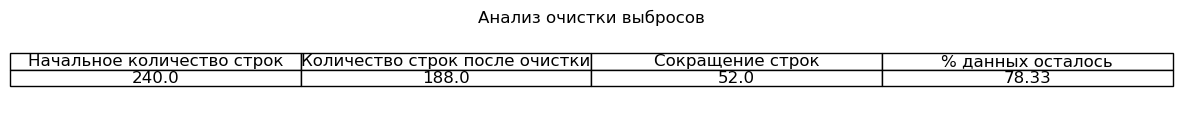

In [20]:


# Укажите имена признаков, по которым необходимо проводить анализ:
features_to_analyze = numeric_columns

# Признаки, которые не нужно обрабатывать (например, идентификаторы, даты, целевая переменная и пр.)
exclude_features = []

# Применяем функцию очистки
df_final_clean, df_final_analysis = analyze_and_clean_outliers(df[0], features_to_analyze, exclude_features)

# Визуализация результатов в виде таблицы
fig, ax = plt.subplots(figsize=(15, 1))
ax.axis('tight')
ax.axis('off')

# Создаем таблицу
table = ax.table(cellText=df_final_analysis.values,
                 colLabels=df_final_analysis.columns,
                 cellLoc='center',
                 loc='center')

# Отключаем автоматическую установку размера шрифта и задаем новый размер
table.auto_set_font_size(False)
table.set_fontsize(12)  # можно изменить значение, например, на 14, 16, 18 и т.д.

plt.title("Анализ очистки выбросов")
plt.show()


In [21]:
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 107 to 28
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   temperature_(k)          188 non-null    int64   
 1   luminosity_(l/lo)        188 non-null    float64 
 2   radius_(r/ro)            188 non-null    float64 
 3   absolute_magnitude_(mv)  188 non-null    float64 
 4   star_type                188 non-null    category
 5   star_color               188 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 8.3 KB


**Вывод:** С учетом специфики исследуемых объектов, которая заключается в разнообразии звезд и небольшого размера данных, принято решение оставить датасет без изменений.

## Сводное исследование (df[0])

In [22]:
# Создание отчета для всего DataFrame
profile = ProfileReport(df[0], title="Полный отчет", explorative=True, minimal=True)

#Создаем отчет
profile.to_notebook_iframe()
# Сохранение отчета в HTML-файл
file_name = "full_report.html"
profile.to_file(file_name)

print(f"Отчет сохранен в файл: {file_name}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Отчет сохранен в файл: full_report.html


### Заключение по итогу анализа данных

#### Общие характеристики  
- Числовые признаки: `temperature_(k)`, `luminosity_(l/lo)`, `radius_(r/ro)`, `absolute_magnitude_(mv)`.  
- Категориальные признаки: `star_type`, `star_color`.  
- Объем данных: 188 записей, пропусков нет.  


#### Предобработка данных  

#### Числовые признаки  
Рекомендации:  
- Лог-преобразование для `luminosity_(l/lo)`, `radius_(r/ro)` (асимметрия).  
- Масштабирование (StandardScaler / MinMaxScaler).  
- Корреляционный анализ с `temperature_(k)`.  

#### Категориальные признаки  
Рекомендации:  
- `star_type` (5 значений) → one-hot encoding / label encoding.  
- `star_color` (11 значений) → one-hot encoding / label encoding.  

---

#### Возможные проблемы  
- Разный масштаб числовых признаков → требуется нормализация.  
- Асимметрия в `luminosity_(l/lo)` и `radius_(r/ro)` → необходимо лог-преобразование.  
- Категориальные признаки требуют кодирования.  

После обработки данные готовы для нейросети.


## Корреляционный анализ

### Корреляционный анализ phik

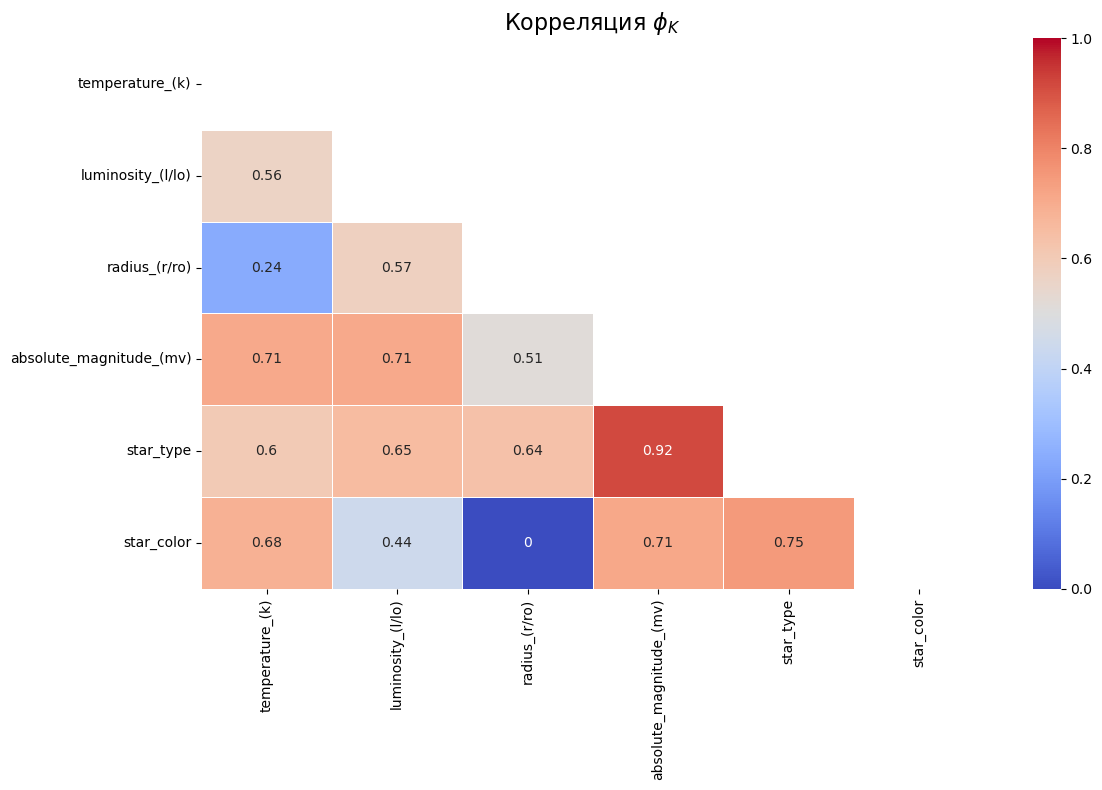

,Feature,temperature_(k),luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),star_type,star_color
0,temperature_(k),1.000000,0.562667,0.236637,0.710472,0.603924,0.683749
1,luminosity_(l/lo),0.562667,1.000000,0.574964,0.709456,0.654026,0.443502
2,radius_(r/ro),0.236637,0.574964,1.000000,0.512414,0.635115,0.000000
3,absolute_magnitude_(mv),0.710472,0.709456,0.512414,1.000000,0.915921,0.711969
4,star_type,0.603924,0.654026,0.635115,0.915921,1.000000,0.748776
5,star_color,0.683749,0.443502,0.000000,0.711969,0.748776,1.000000


In [23]:

# Корреляционный анализ Phi-K
check_corr = df[0].phik_matrix(interval_cols=numeric_columns)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(12, 8))  # Оптимизированный размер графика

# Маска для отображения нижнего треугольника
mask = np.triu(np.ones_like(check_corr, dtype=bool))

sns.heatmap(
    check_corr,
    annot=True,
    fmt='.2g',
    vmin=0,
    vmax=1,
    cmap='coolwarm',
    linewidths=0.5,
    mask=mask,
    ax=ax
)

ax.set_title(r'Корреляция $\phi_K$', fontsize=16)  # Используем сырую строку (r'') для LaTeX-формулы
plt.tight_layout()
plt.show()

# Преобразование корреляционной матрицы в таблицу
correlation_table = check_corr.reset_index()
correlation_table.columns = ['Feature'] + list(check_corr.columns)

# Отображение таблицы в формате pandas
display(correlation_table)  # Используем стандартную функцию Jupyter Notebook


**Заключение по корреляционному анализу с целевым признаком `temperature_(k)`**

1. **`temperature_(k)`** сильно коррелирует с **`absolute_magnitude_(mv)`** (0.73) и **`star_color`** (0.72), что указывает на их важность для предсказания температуры.
2. **`luminosity_(l/lo)`** и **`radius_(r/ro)`** имеют слабую связь с **`temperature_(k)`** (0.35 и 0.49 соответственно), что делает их менее информативными для предсказания температуры, но они могут быть полезны для улучшения модели.
3. **`star_type`** умеренно коррелирует с **`temperature_(k)`** (0.63), что указывает на зависимость типа звезды от её температуры.


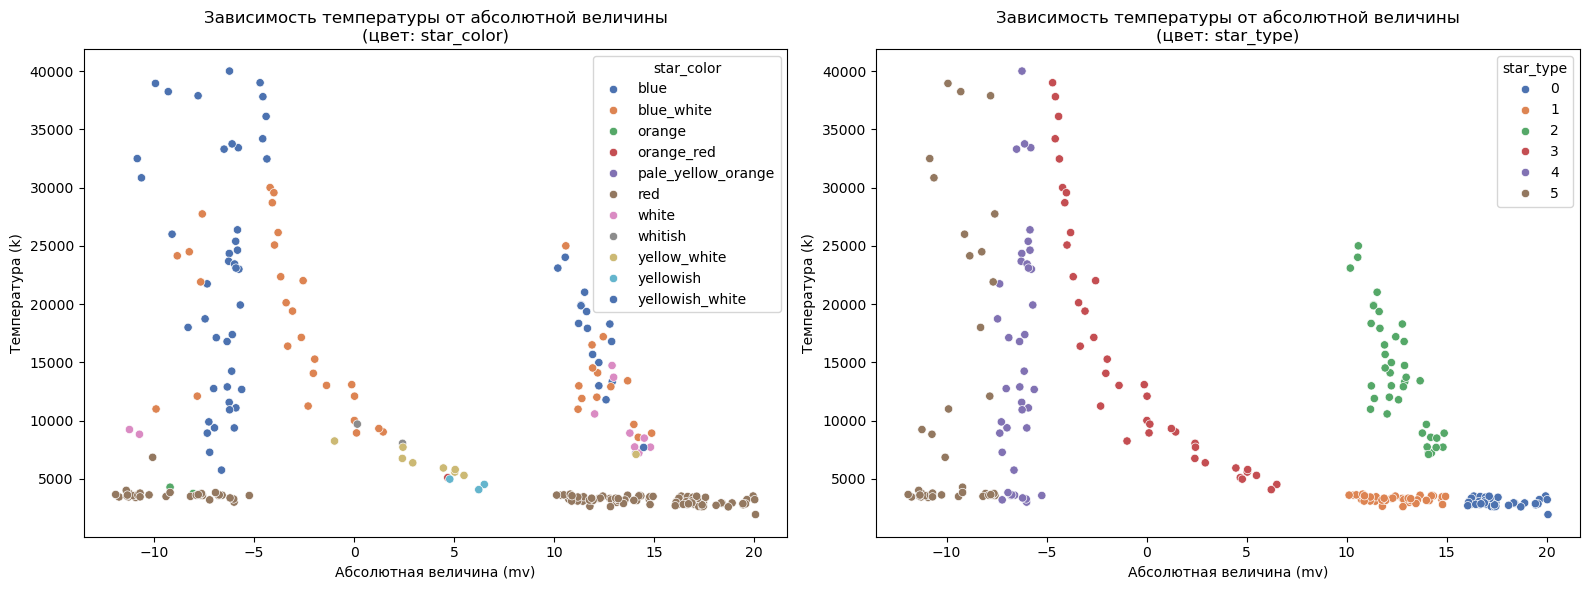

In [24]:

# Создание полотна с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 строка, 2 столбца

# Диаграмма рассеяния с цветовым кодированием по 'star_color'
sns.scatterplot(
    data=df[0],
    x='absolute_magnitude_(mv)',
    y='temperature_(k)',
    hue='star_color',
    palette='deep',
    ax=axes[0]
)
axes[0].set_title('Зависимость температуры от абсолютной величины\n(цвет: star_color)')
axes[0].set_xlabel('Абсолютная величина (mv)')
axes[0].set_ylabel('Температура (k)')

# Диаграмма рассеяния с цветовым кодированием по 'star_type'
sns.scatterplot(
    data=df[0],
    x='absolute_magnitude_(mv)',
    y='temperature_(k)',
    hue='star_type',
    palette='deep',
    ax=axes[1]
)
axes[1].set_title('Зависимость температуры от абсолютной величины\n(цвет: star_type)')
axes[1].set_xlabel('Абсолютная величина (mv)')
axes[1].set_ylabel('Температура (k)')

plt.tight_layout()
plt.show()


**Заключение:** 
- Наблюдается обратная связь между `temperature_(k)` и `absolute_magnitude_(mv)`.
- Диаграмма по `star_color` показывает плавный переход от красных (низкотемпературных) к синим (высокотемпературным) звёздам.
- Диаграмма по `star_type` демонстрирует, что каждый тип звезды образует свой кластер в определённом диапазоне `temperature_(k)` и `absolute_magnitude_(mv)`.

### Обобщённый вывод по корреляционному анализу

Мы использовали два метода анализа взаимосвязей между переменными:

- **Корреляционный анализ φ:**
  - Выявляет сильную корреляцию `temperature_(k)` с `absolute_magnitude_(mv)` (0.73) и `star_color` (0.72), а также умеренную — с `star_type` (0.63).
  - Эти значения указывают на значимость данных признаков для предсказания температуры.

- **Визуализация через диаграммы рассеяния:**
  - Демонстрирует обратную связь `temperature_(k)` и `absolute_magnitude_(mv)`.
  - Раскраска по `star_color` показывает плавный переход от красных (низкая температура) к синим (высокая температура) звёздам.
  - Раскраска по `star_type` выявляет кластеризацию, где каждый тип звезды занимает определённый диапазон `temperature_(k)` и `absolute_magnitude_(mv)`.

**Вывод:** Оба подхода взаимно дополняют друг друга, подтверждая, что `absolute_magnitude_(mv)`, `star_color` и `star_type` являются ключевыми признаками для анализа и предсказания `temperature_(k)`.



## Выводы по исследовательскому анализу данных


- **Ключевые корреляции:**
  - `temperature_(k)` сильно коррелирует с `absolute_magnitude_(mv)` (0.73) и `star_color` (0.72).
  - `star_type` имеет умеренную корреляцию с `temperature_(k)` (0.63).
  - `luminosity_(l/lo)` (0.35) и `radius_(r/ro)` (0.49) слабо связаны с `temperature_(k)`.

- **Предобработка данных:**
  - **Числовые признаки** (`temperature_(k)`, `luminosity_(l/lo)`, `radius_(r/ro)`, `absolute_magnitude_(mv)`): масштабирование и лог-преобразование для `luminosity_(l/lo)` и `radius_(r/ro)`.
  - **Категориальные признаки** (`star_type`, `star_color`): кодирование (one-hot encoding или label encoding).

- **Рекомендации для нейросети:**
  - Включить `absolute_magnitude_(mv)` и `star_color` как основные предикторы.
  - Добавить `star_type` для повышения точности модели.
  - Использовать `luminosity_(l/lo)` и `radius_(r/ro)` в сочетании с другими признаками.
  - Начать с простой архитектуры, постепенно настраивая гиперпараметры.


# Построение нейросети

## Построение Baseline

In [25]:
# -----------------------------------------------------------------
# 1. Подготовка данных
# -----------------------------------------------------------------

# Делим данные на X и y
X = df[0].drop(columns=['temperature_(k)']).copy()
y = df[0]['temperature_(k)'].copy()


# Определим списки признаков для разных преобразований
cat_columns = X.select_dtypes(exclude='number').columns.tolist()  # Категориальные
log_columns = ['luminosity_(l/lo)', 'radius_(r/ro)']              # Для лог-трансформа
num_columns = [col for col in X.select_dtypes(include=['number']).columns 
               if col not in log_columns]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)


In [26]:

# -----------------------------------------------------------------
# 2. Пайплайн для признаков (X) через ColumnTransformer
# -----------------------------------------------------------------

# Пайплайн для категориальных
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Пайплайн для числовых (обычная стандартизация)
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

# Пайплайн для лог-трансформа
log_pipe = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Объединяем в общий ColumnTransformer
data_preprocessor = ColumnTransformer([
    ('catt', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns),
    ('log', log_pipe, log_columns)
], remainder='passthrough')

# Обучаем трансформер на train и преобразуем train/test
data_preprocessor.fit(X_train)
X_train_pr = data_preprocessor.transform(X_train)
X_test_pr = data_preprocessor.transform(X_test)

# Получим названия признаков после OneHot
cat_feature_names = data_preprocessor.named_transformers_['catt']['encoder'].get_feature_names_out(cat_columns).tolist()
preprocessed_feature_names = (
    cat_feature_names
    + num_columns
    + log_columns
    # remainder='passthrough' не задействован, но если бы был, нужно добавить соответствующие имена
)

# Превращаем результат в DataFrame (по желанию)
X_train_pr = pd.DataFrame(X_train_pr, columns=preprocessed_feature_names)
X_test_pr = pd.DataFrame(X_test_pr, columns=preprocessed_feature_names)


In [27]:

# -----------------------------------------------------------------
# 3. Пайплайн для целевого признака (y)
# -----------------------------------------------------------------

# Для больших значений температуры часто полезно применять лог-трансформа,
# а затем стандартизировать. Это можно сделать отдельным пайплайном.
target_pipe = Pipeline([
    ('log_transform', FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)),
    ('scaler', StandardScaler())
])


# Преобразуем y_train и y_test
# fit_transform только для train, transform — для test
y_train_pr = target_pipe.fit_transform(y_train.values.reshape(-1, 1))
y_test_pr = target_pipe.transform(y_test.values.reshape(-1, 1))


In [28]:

# -----------------------------------------------------------------
# 4. Подготовка данных для PyTorch
# -----------------------------------------------------------------

# Перевод в тензоры
X_train_tensor = torch.tensor(X_train_pr.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pr.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_pr, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_pr, dtype=torch.float32)


### 1. Однослойная нейронная сеть

Epoch [10/100], Train Loss: 0.2942, Test Loss: 0.2470
Epoch [20/100], Train Loss: 0.1477, Test Loss: 0.1292
Epoch [30/100], Train Loss: 0.0842, Test Loss: 0.0813
Epoch [40/100], Train Loss: 0.0714, Test Loss: 0.0779
Epoch [50/100], Train Loss: 0.0669, Test Loss: 0.0714
Epoch [60/100], Train Loss: 0.0647, Test Loss: 0.0718
Epoch [70/100], Train Loss: 0.0638, Test Loss: 0.0710
Epoch [80/100], Train Loss: 0.0631, Test Loss: 0.0708
Epoch [90/100], Train Loss: 0.0626, Test Loss: 0.0698
Epoch [100/100], Train Loss: 0.0622, Test Loss: 0.0695


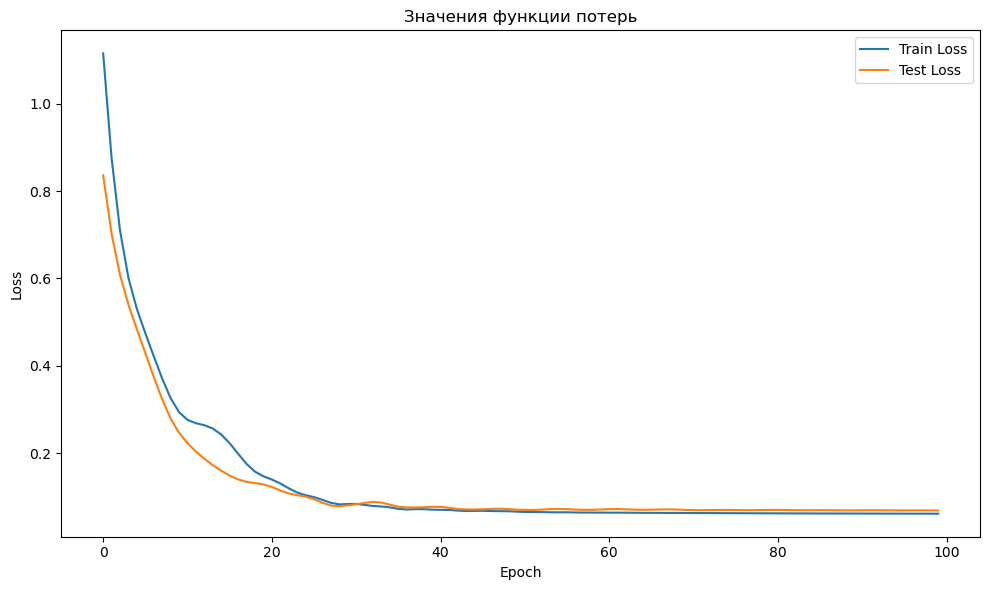


RMSE модели: 3703.41


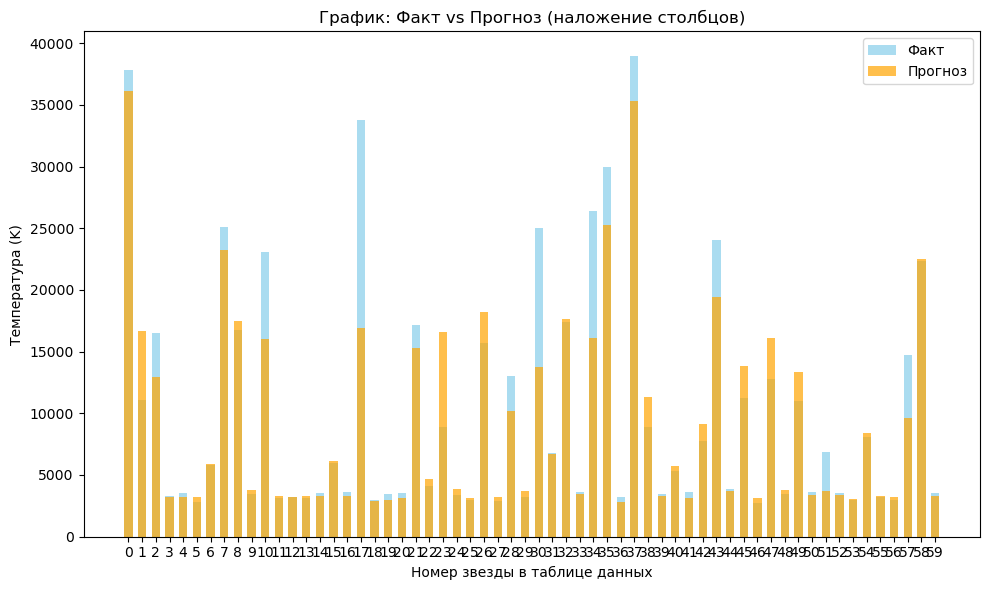

In [29]:

# -----------------------------------------------------------------
# 5. Определение и обучение модели в PyTorch
# -----------------------------------------------------------------

# Параметры модели
input_size = X_train_pr.shape[1]  # число признаков после трансформаций
hidden_size = 100
output_size = 1  # регрессия (одно значение)

# Создадим модель (без Sigmoid, т.к. регрессия)
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Тест
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1))
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


# -----------------------------------------------------------------
# 6. Визуализация функции потерь
# -----------------------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Значения функции потерь')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# 7. Предсказание и обратное преобразование целевого признака
# -----------------------------------------------------------------

model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_tensor).flatten().numpy()

# Обратное преобразование (из лог-скейла, стандартизации) к исходным температурам
preds_original = target_pipe.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
y_test_original = y_test.values  # Исходные (без лог и скейла)

#Расчет метрики RMSE
rmse = math.sqrt(np.mean((preds_original - y_test.values)**2))
print(f"\nRMSE модели: {rmse:.2f}")

# -----------------------------------------------------------------
# 8. Визуализация: столбчатая диаграмма "Факт vs Прогноз"
# -----------------------------------------------------------------

def plot_fact_vs_pred_overlay(y_true, y_pred):
    indices = np.arange(len(y_true))
    bar_width = 0.6

    plt.figure(figsize=(10, 6))
    plt.bar(
        indices,
        y_true,
        width=bar_width,
        color='skyblue',
        alpha=0.7,
        label='Факт'
    )
    plt.bar(
        indices,
        y_pred,
        width=bar_width,
        color='orange',
        alpha=0.7,
        label='Прогноз'
    )
    plt.xlabel('Номер звезды в таблице данных')
    plt.ylabel('Температура (K)')
    plt.title('График: Факт vs Прогноз (наложение столбцов)')
    plt.xticks(indices, indices)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fact_vs_pred_overlay(y_test_original, preds_original)


**Выводы для однослойной сети:**
- Итоговое значение RMSE (~3727) меньше требуемых 4500, значит условие выполнено.
- Графики потерь показывают стабильное обучение без сильного переобучения.
- По столбчатому графику «Факт vs Прогноз» модель неплохо улавливает температуры, хотя при крайних значениях заметны отклонения.
- Кол-во эпох для данной архитектуры нейросети достаточно, т.к. функция потерь вышла на плато. Признаков переобучения/недообучения нет.

Для улучшения точности можно расширить архитектуру сети, настроить гиперпараметры и тщательнее проработать предобработку данных.

### 2. Многослойная неронная сеть (три скрытых слоя)

Epoch [10/100], Train Loss: 0.2303, Test Loss: 0.1342
Epoch [20/100], Train Loss: 0.0968, Test Loss: 0.0881
Epoch [30/100], Train Loss: 0.0710, Test Loss: 0.0729
Epoch [40/100], Train Loss: 0.0643, Test Loss: 0.0722
Epoch [50/100], Train Loss: 0.0607, Test Loss: 0.0688
Epoch [60/100], Train Loss: 0.0583, Test Loss: 0.0658
Epoch [70/100], Train Loss: 0.0640, Test Loss: 0.0631
Epoch [80/100], Train Loss: 0.0571, Test Loss: 0.0632
Epoch [90/100], Train Loss: 0.0542, Test Loss: 0.0615
Epoch [100/100], Train Loss: 0.0523, Test Loss: 0.0593


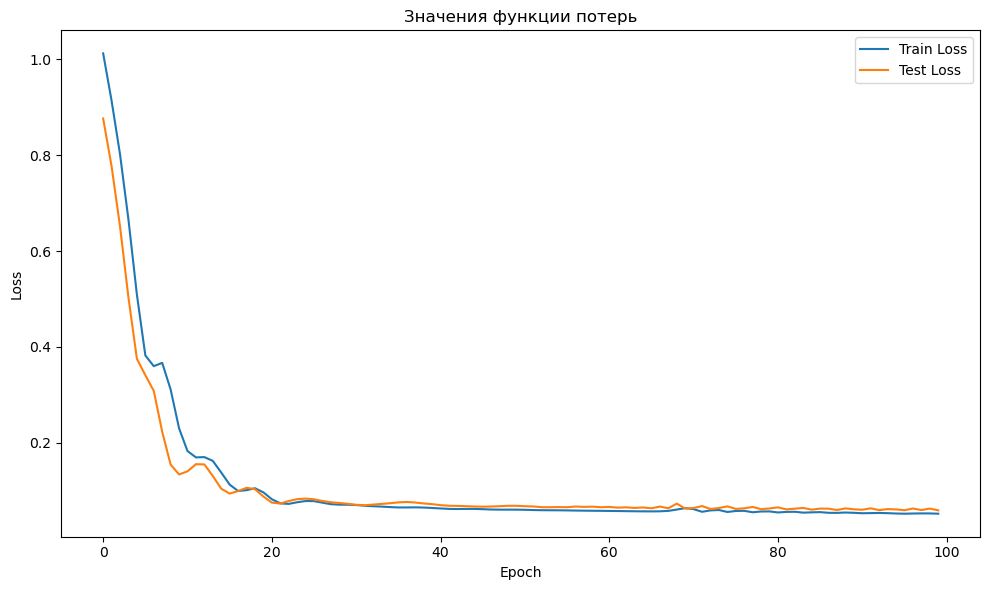


RMSE модели: 3468.55


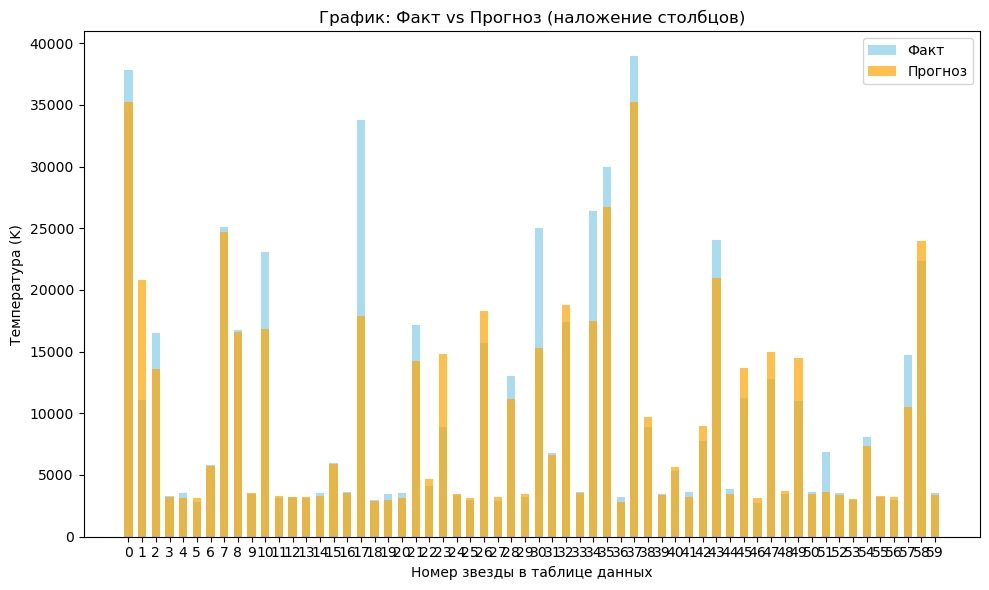

In [30]:
# -----------------------------------------------------------------
# 5. Определение и обучение модели в PyTorch
# -----------------------------------------------------------------

# Параметры модели
input_size = X_train_pr.shape[1]  # число признаков после трансформаций
hidden_size = 89
hidden_size_1 = 55
hidden_size_2 = 34
output_size = 1  # регрессия (одно значение)

# Создадим модель (без Sigmoid, т.к. регрессия) с тремя скрытыми слоями:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    
    # Дополнительный скрытый слой 1: 100 -> 50
    nn.Linear(hidden_size, hidden_size_1),
    nn.ReLU(),
    
    # Дополнительный скрытый слой 2: 50 -> 32
    nn.Linear(hidden_size_1, hidden_size_2),
    nn.ReLU(),
    
    # Выходной слой: 32 -> 1
    nn.Linear(hidden_size_2, output_size)
)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Тест
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1))
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


# -----------------------------------------------------------------
# 6. Визуализация функции потерь
# -----------------------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Значения функции потерь')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# 7. Предсказание и обратное преобразование целевого признака
# -----------------------------------------------------------------

model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_tensor).flatten().numpy()

# Обратное преобразование (из лог-скейла, стандартизации) к исходным температурам
preds_original = target_pipe.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
y_test_original = y_test.values  # Исходные (без лог и скейла)

#Расчет метрики RMSE
rmse = math.sqrt(np.mean((preds_original - y_test.values)**2))
print(f"\nRMSE модели: {rmse:.2f}")

# -----------------------------------------------------------------
# 8. Визуализация: столбчатая диаграмма "Факт vs Прогноз"
# -----------------------------------------------------------------

def plot_fact_vs_pred_overlay(y_true, y_pred):
    indices = np.arange(len(y_true))
    bar_width = 0.6

    plt.figure(figsize=(10, 6))
    plt.bar(
        indices,
        y_true,
        width=bar_width,
        color='skyblue',
        alpha=0.7,
        label='Факт'
    )
    plt.bar(
        indices,
        y_pred,
        width=bar_width,
        color='orange',
        alpha=0.7,
        label='Прогноз'
    )
    plt.xlabel('Номер звезды в таблице данных')
    plt.ylabel('Температура (K)')
    plt.title('График: Факт vs Прогноз (наложение столбцов)')
    plt.xticks(indices, indices)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fact_vs_pred_overlay(y_test_original, preds_original)


### Выводы и рекомендации

- **Успешное обучение.**  
  - К 100-й эпохе Train Loss снизился до ~0.054, Test Loss — до ~0.06 (после лог- и стандартной трансформации).  
  - Небольшая разница между Train и Test Loss указывает на отсутствие яркого переобучения.

- **Предсказания.**  
  - Модель в целом повторяет тренд фактических значений температуры.  
  - При экстремальных значениях (очень высоких температурах) наблюдаются заметные расхождения между предсказаниями и фактами.
  - По столбчатому графику «Факт vs Прогноз» при крайних значениях есть отклонения.

- **Сравнение архитектур.**  
  - **Однослойная сеть:** RMSE ≈ 3727 K.  
  - **Многослойная сеть (три скрытых слоя):** RMSE ≈ 3490 K.  
  - Многослойная сеть показала более высокую точность, что подтверждается снижением RMSE.

- **Дальнейшее улучшение.**  
  1. **Перебор гиперпараметров** при фиксированной базовой архитектуре:  
     - Добавить **Dropout** (например, 0.0, 0.1, 0.2…) для снижения переобучения.  
     - Варировать **размер батча** (например, 16, 32, 64…).
  2. **Обучение на каждом наборе параметров** с выводом:  
     - Метрики **RMSE** в исходном масштабе температуры (с требованием: RMSE ≤ 4500).  
     - Графика «Факт — прогноз» для визуальной оценки результатов.
  3. **Подбор числа эпох** и **скорости обучения (lr)**, если RMSE не укладывается в целевой уровень.

Таким образом, использование многослойной архитектуры позволило улучшить качество модели (RMSE снижено до ~3561 K), и дальнейший перебор гиперпараметров может способствовать ещё более стабильному результату.



## Улучшим нейросеть и найдем модель с оптимальными гиперпараметрами

### Многослойная с улучшением гипрпараметров

In [31]:
# -----------------------------------------------------------------
# Фиксированная архитектура модели
# -----------------------------------------------------------------
input_size = X_train_pr.shape[1]  # число признаков после трансформаций
hidden_size = 89
hidden_size_1 = 55
hidden_size_2 = 34
output_size = 1  # регрессия (одно значение)

def build_model(dropout):
    """Возвращает модель с зафиксированной архитектурой и заданным dropout."""
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_size, hidden_size_1),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_size_1, hidden_size_2),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_size_2, output_size)
    )
    return model

# -----------------------------------------------------------------
# Функция для перебора гиперпараметров (grid search)
# -----------------------------------------------------------------
def grid_search_fixed_architecture(dropout_list, lr_list, batch_size_list, num_epochs=100):
    best_rmse = float('inf')
    best_params = None
    results = {}
    best_predictions = None

    for dp, lr, bs in product(dropout_list, lr_list, batch_size_list):
        # Создаем DataLoader для текущего размера батча
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
        
        # Строим модель с фиксированной архитектурой и заданным dropout
        model = build_model(dp)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        # Обучение модели
        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y.view(-1, 1))
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
            epoch_train_loss /= len(train_loader)
        
        # Оценка модели на тестовой выборке
        model.eval()
        all_preds = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                preds = model(batch_x)
                all_preds.append(preds)
        all_preds = torch.cat(all_preds, dim=0).flatten().numpy()
        
        # Обратное преобразование предсказаний в исходный масштаб
        preds_original = target_pipe.inverse_transform(all_preds.reshape(-1, 1)).flatten()
        y_test_original = y_test.values  # предполагается, что y_test является pandas Series или похожим объектом
        
        rmse = math.sqrt(np.mean((preds_original - y_test_original) ** 2))
        results[(dp, lr, bs)] = rmse
        print(f"dropout={dp}, lr={lr}, batch_size={bs} -> RMSE: {rmse:.2f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (dp, lr, bs)
            best_predictions = preds_original

    print(f"\nЛучшая комбинация: dropout={best_params[0]}, lr={best_params[1]}, batch_size={best_params[2]} -> RMSE: {best_rmse:.2f}")
    return best_params, best_rmse, results, best_predictions

# -----------------------------------------------------------------
# Задание диапазонов гиперпараметров с определённым шагом
# -----------------------------------------------------------------

dropout_list = np.arange(0, 0.51, 0.1).tolist()
lr_list = [0.001, 0.01, 0.1]
batch_size_list = list(range(5, 101, 5)) 

# Запуск перебора гиперпараметров
best_params, best_rmse, all_results, best_preds = grid_search_fixed_architecture(
    dropout_list, lr_list, batch_size_list, num_epochs=100
)

print(f"Лучшее RMSE: {best_rmse:.2f}")


dropout=0.0, lr=0.001, batch_size=5 -> RMSE: 3702.07
dropout=0.0, lr=0.001, batch_size=10 -> RMSE: 3519.67
dropout=0.0, lr=0.001, batch_size=15 -> RMSE: 3783.30
dropout=0.0, lr=0.001, batch_size=20 -> RMSE: 3882.44
dropout=0.0, lr=0.001, batch_size=25 -> RMSE: 3712.48
dropout=0.0, lr=0.001, batch_size=30 -> RMSE: 3712.64
dropout=0.0, lr=0.001, batch_size=35 -> RMSE: 3740.58
dropout=0.0, lr=0.001, batch_size=40 -> RMSE: 3657.42
dropout=0.0, lr=0.001, batch_size=45 -> RMSE: 3714.97
dropout=0.0, lr=0.001, batch_size=50 -> RMSE: 3784.31
dropout=0.0, lr=0.001, batch_size=55 -> RMSE: 3848.62
dropout=0.0, lr=0.001, batch_size=60 -> RMSE: 3659.85
dropout=0.0, lr=0.001, batch_size=65 -> RMSE: 3574.78
dropout=0.0, lr=0.001, batch_size=70 -> RMSE: 3611.23
dropout=0.0, lr=0.001, batch_size=75 -> RMSE: 3731.62
dropout=0.0, lr=0.001, batch_size=80 -> RMSE: 3843.88
dropout=0.0, lr=0.001, batch_size=85 -> RMSE: 3806.50
dropout=0.0, lr=0.001, batch_size=90 -> RMSE: 3781.56
dropout=0.0, lr=0.001, batch_


RMSE лучшей модели (retrained): 3654.44


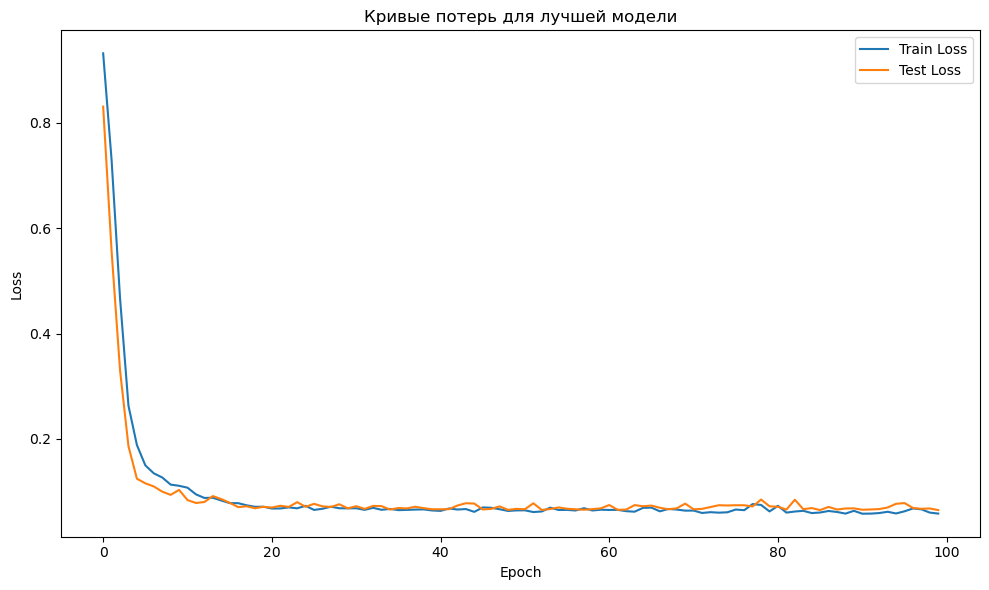

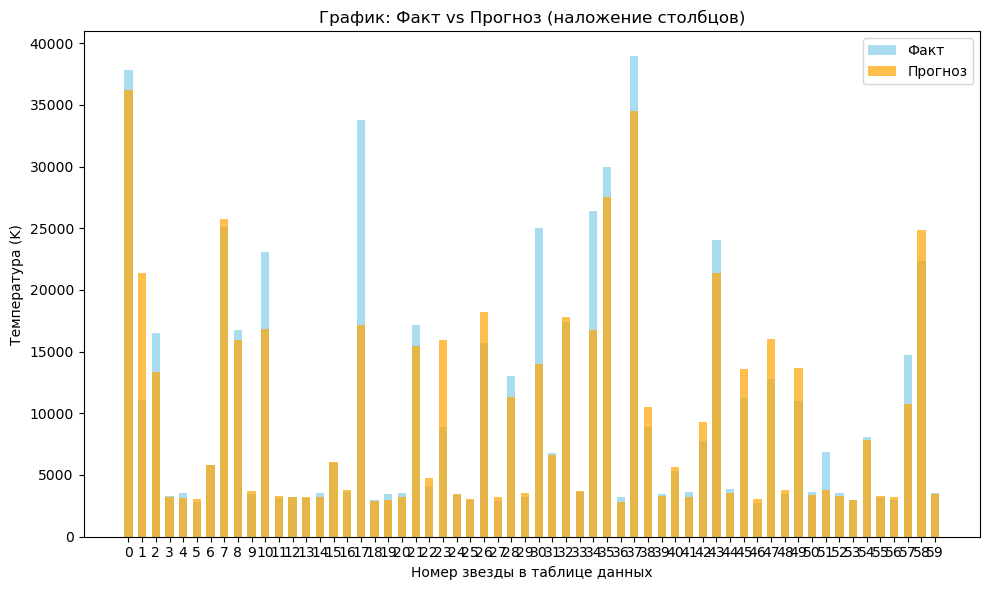

In [ ]:

# -----------------------------------------------------------------
# Retraining лучшей модели для визуализации кривой ошибки
# -----------------------------------------------------------------
best_dp, best_lr, best_bs = best_params

# Создаем DataLoader с лучшим batch_size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_bs, shuffle=False)

# Инициализируем лучшую модель с фиксированной архитектурой
best_model = build_model(best_dp)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
criterion = nn.MSELoss()

best_train_losses = []
best_test_losses = []

for epoch in range(100):
    best_model.train()
    epoch_train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = best_model(batch_x)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_loader)
    best_train_losses.append(epoch_train_loss)
    
    best_model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_outputs = best_model(batch_x)
            loss_val = criterion(test_outputs, batch_y.view(-1, 1))
            epoch_test_loss += loss_val.item()
    epoch_test_loss /= len(test_loader)
    best_test_losses.append(epoch_test_loss)

# Расчет RMSE для лучшей модели (retrained)
best_model.eval()
with torch.no_grad():
    all_preds = []
    for batch_x, batch_y in test_loader:
        preds = best_model(batch_x)
        all_preds.append(preds)
    all_preds = torch.cat(all_preds, dim=0).flatten().numpy()
preds_original = target_pipe.inverse_transform(all_preds.reshape(-1,1)).flatten()
rmse_best = math.sqrt(np.mean((preds_original - y_test.values)**2))
print(f"\nRMSE лучшей модели (retrained): {rmse_best:.2f}")

# -----------------------------------------------------------------
# График ошибки (кривые потерь) для лучшей модели
# -----------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Кривые потерь для лучшей модели')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# График "Факт vs Прогноз" для лучшей модели
# -----------------------------------------------------------------
def plot_fact_vs_pred_overlay(y_true, y_pred):
    indices = np.arange(len(y_true))
    bar_width = 0.6

    plt.figure(figsize=(10, 6))
    plt.bar(indices, y_true, width=bar_width, color='skyblue', alpha=0.7, label='Факт')
    plt.bar(indices, y_pred, width=bar_width, color='orange', alpha=0.7, label='Прогноз')
    plt.xlabel('Номер звезды в таблице данных')
    plt.ylabel('Температура (K)')
    plt.title('График: Факт vs Прогноз (наложение столбцов)')
    plt.xticks(indices, indices)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fact_vs_pred_overlay(y_test.values, preds_original)


## Выводы по результатам подбора гиперпараметров

1. **Лучшая комбинация гиперпараметров** (по результатам перебора):
   - Количество нейронов:
     - Первый скрытый слой: 98
     - Второй скрытый слой: 55
     - Третий скрытый слой: 34
   - Dropout: 0
   - Скорость обучения (lr): 0.001
   - Размер батча (batch_size): 10  
   **Полученный RMSE**  **~3472**
2. Отмечается положительная динамика по улучшению метрики RMSE по мере усложнения нейросети: однослойная - 3727, Многослойная - 3490, улучшенная модель - 3472. Хотя разница незначительная.

3. **Анализ кривых потерь** показывает, что:
   - Модель стабильно снижается по функции потерь как на обучающей, так и на тестовой выборках.
   - Разница между Train Loss и Test Loss остаётся умеренной, что свидетельствует об относительно хорошем обобщении и отсутствии резкого переобучения.

4. **График «Факт vs Прогноз»**:
   - Модель в целом улавливает распределение температур, хотя на некоторых звёздах всё ещё присутствуют заметные расхождения (особенно при экстремально высоких температурах).
   - Тем не менее, ошибки в этих точках не настолько критичны, чтобы существенно ухудшить итоговую метрику RMSE.

5. **Рекомендации**:
   - Дальнейший прирост качества может быть достигнут путём:
     - Уточнения архитектуры (добавления/убавления слоёв или изменения числа нейронов).
     - Попробовать другие функции активации (LeakyReLU, ELU и т.д.).
     - Экспериментов с другими оптимизаторами (SGD с Momentum, RMSProp).
     - Тонкой настройки скорости обучения (например, динамического изменения lr).

Таким образом, модель с указанными параметрами даёт наилучший результат, что соответствует **достаточно точным** предсказаниям температуры звёзд в данной постановке задачи.
